# Agentic Predictive Maintenance for Insured Assets
---
**Objective:** Develop an agentic predictive maintenance solution using time-series sensor data.

**Core Components:**
* **Data:** Time-series sensor data, policy data, and maintenance logs/manuals.
* **Model:** Time-aware model selection (forecasting/classification) and hyperparameter tuning.
* **Agent:** An AI agent combining deterministic checks, RAG (retrieval from manuals), and LLM reasoning to provide explainable maintenance recommendations.

## 1. Data Exploration & Preprocessing 

This cell defines all necessary functions to ingest, clean, and prepare all four CMAPSS datasets (FD001-FD004).

The script performs the following key actions:
* **Loads:** Reads the raw `train_FD00X.txt`, `test_FD00X.txt`, and `RUL_FD00X.txt` files.
* **Calculates RUL:** Computes the 'Remaining Useful Life' (RUL) target label for every row in both the training and test sets.
* **Applies Normalization:**
    * Uses a **global `StandardScaler`** for FD001 & FD003.
    * Uses a **conditional (cluster-based) `StandardScaler`** for FD002 & FD004, which have multiple operating conditions.
* **Generates EDA:** Displays summary statistics and correlation/sensor plots for each subset.
* **Saves Artifacts:** Exports the final processed DataFrames as `.csv` files to `data/processed/` and the fitted `StandardScaler` objects as `.pkl` files to `artifacts/scalers/` for use in later steps.


🚀 Starting Data Ingestion Script in Notebook...
Project Root: C:\myProjects\Agentic-Predictive-Maintenance\notebooks
Loading Raw Data From: C:\myProjects\Agentic-Predictive-Maintenance\data\raw\CMAPSS
Saving Processed Data To: C:\myProjects\Agentic-Predictive-Maintenance\data\processed\CMAPSS
Saving Scalers To: C:\myProjects\Agentic-Predictive-Maintenance\artifacts\scalers
--- Processing FD001 ---
Train shape: (20631, 27), Test shape: (13096, 27)
Sensor summary stats (train):
                 mean           std      min      max
sensor_1   518.670000  0.000000e+00   518.67   518.67
sensor_2   642.680934  5.000533e-01   641.21   644.53
sensor_3  1590.523119  6.131150e+00  1571.04  1616.91
sensor_4  1408.933782  9.000605e+00  1382.25  1441.49
sensor_5    14.620000  5.329200e-15    14.62    14.62
Saved global scaler to ..\artifacts\scalers\FD001_global_scaler.pkl
Saved processed files: ..\data\processed\CMAPSS\FD001\train_FD001.csv, ..\data\processed\CMAPSS\FD001\test_FD001.csv
Plotting E

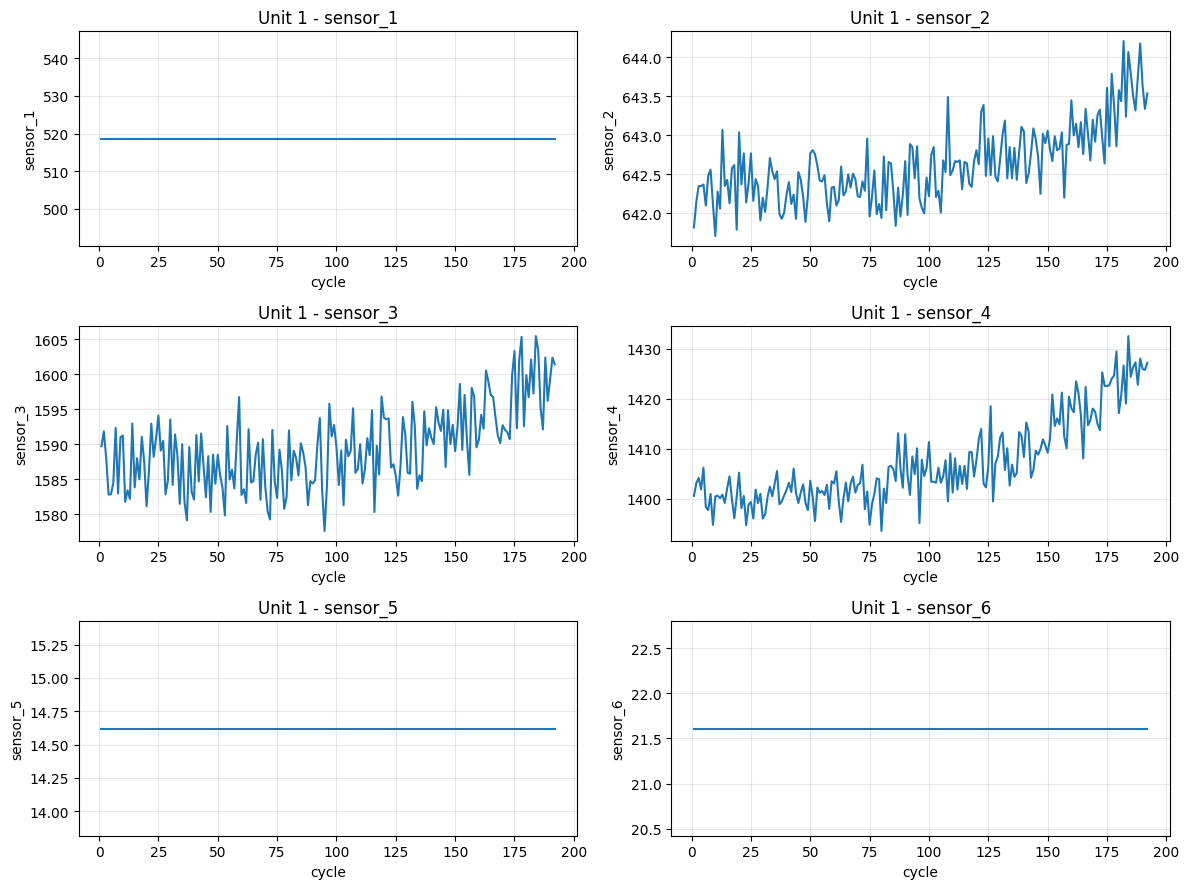

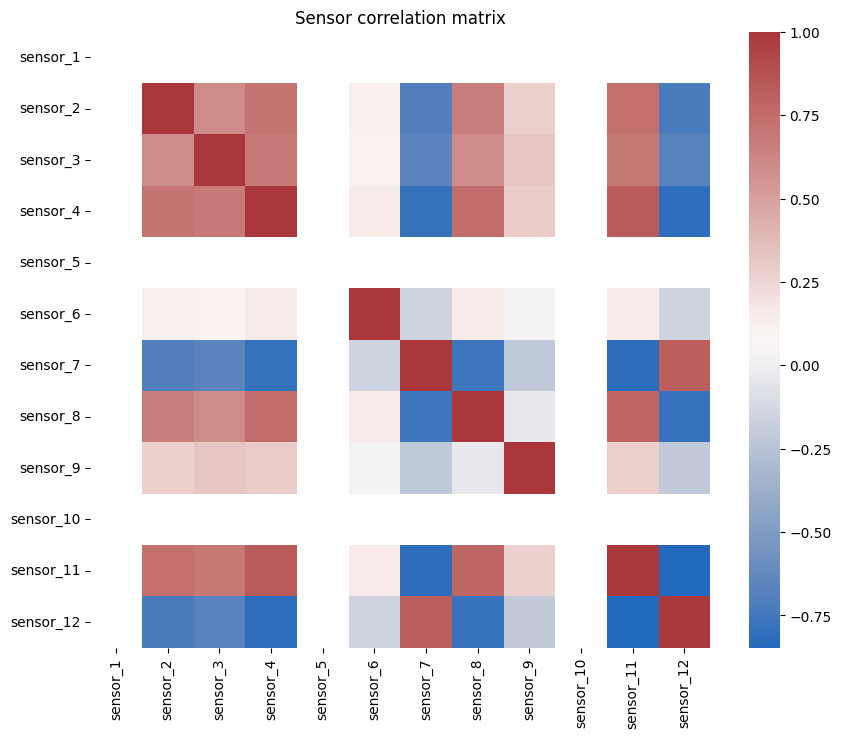

Done plotting.
✅ Successfully processed FD001
--- Processing FD002 ---
Train shape: (53759, 27), Test shape: (33991, 27)
Sensor summary stats (train):
                 mean         std      min      max
sensor_1   472.910207   26.389707   445.00   518.67
sensor_2   579.672399   37.289399   535.53   644.52
sensor_3  1419.971013  105.946341  1243.73  1612.88
sensor_4  1205.442024  119.123428  1023.77  1439.23
sensor_5     8.031986    3.613839     3.91    14.62


C:\Users\sghas\AppData\Local\Temp\ipykernel_21268\1862538827.py:184: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.46286685 -0.60884805 -1.3752494  ...  0.74147812  0.92395463
  0.92395463]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_t.loc[mask_train, cols] = scaler.transform(train_t.loc[mask_train, cols].values)
C:\Users\sghas\AppData\Local\Temp\ipykernel_21268\1862538827.py:184: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.00501045 -0.07022556 -2.10159781 ...  0.69581381  0.66161563
  0.66161563]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_t.loc[mask_train, cols] = scaler.transform(train_t.loc[mask_train, cols].values)
C:\Users\sghas\AppData\Local\Temp\ipykernel_21268\1862538827.py:186: FutureWarning: Setting 

Saved 7 cluster scalers and unit->cluster map for FD002
Saved processed files: ..\data\processed\CMAPSS\FD002\train_FD002.csv, ..\data\processed\CMAPSS\FD002\test_FD002.csv
Plotting EDA graphs for FD002...


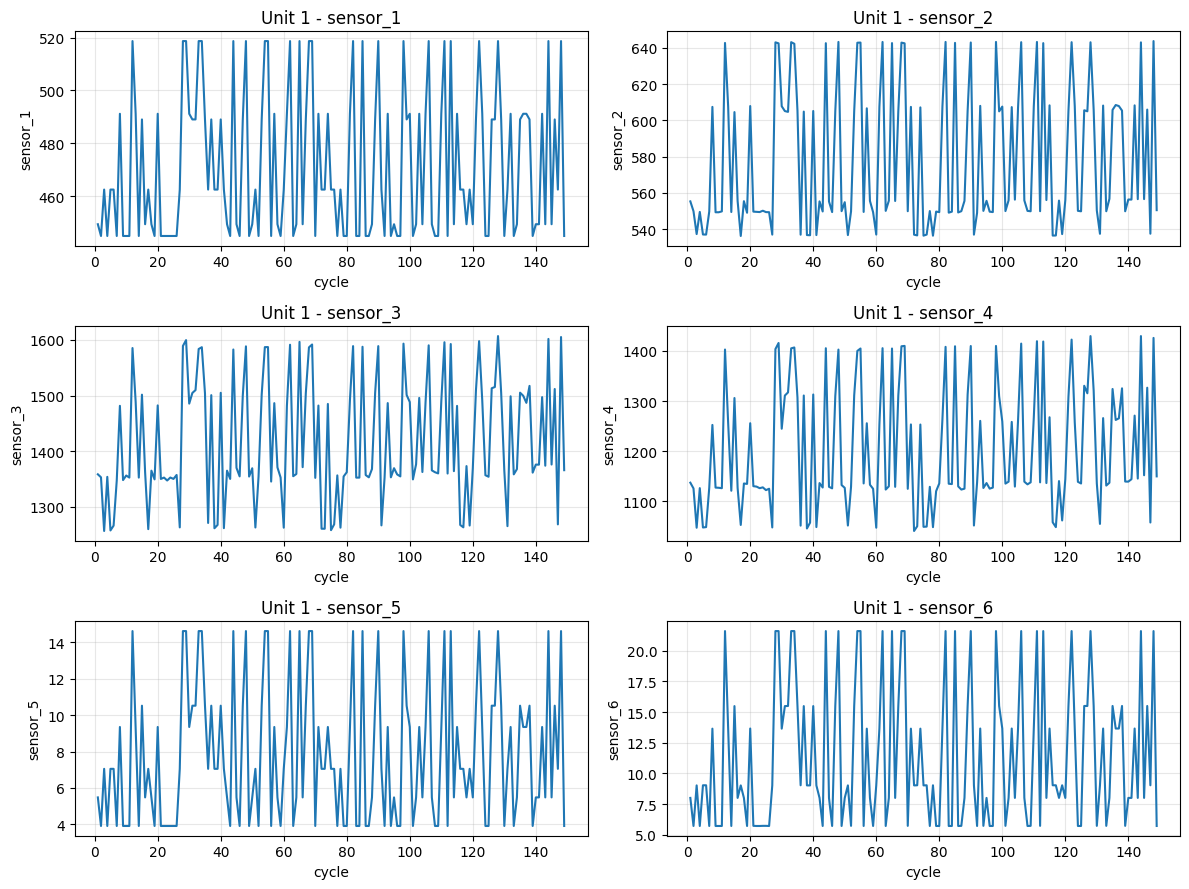

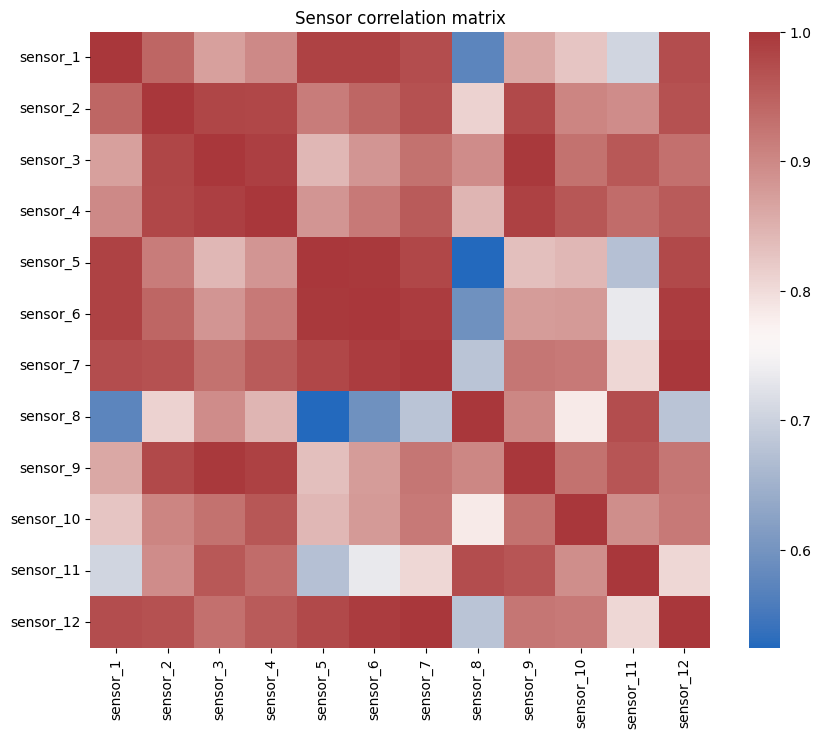

Done plotting.
✅ Successfully processed FD002
--- Processing FD003 ---
Train shape: (24720, 27), Test shape: (16596, 27)
Sensor summary stats (train):
                 mean           std      min      max
sensor_1   518.670000  0.000000e+00   518.67   518.67
sensor_2   642.457858  5.230311e-01   640.84   645.11
sensor_3  1588.079175  6.810418e+00  1564.30  1615.39
sensor_4  1404.471212  9.773178e+00  1377.06  1441.16
sensor_5    14.620000  3.552786e-15    14.62    14.62
Saved global scaler to ..\artifacts\scalers\FD003_global_scaler.pkl
Saved processed files: ..\data\processed\CMAPSS\FD003\train_FD003.csv, ..\data\processed\CMAPSS\FD003\test_FD003.csv
Plotting EDA graphs for FD003...


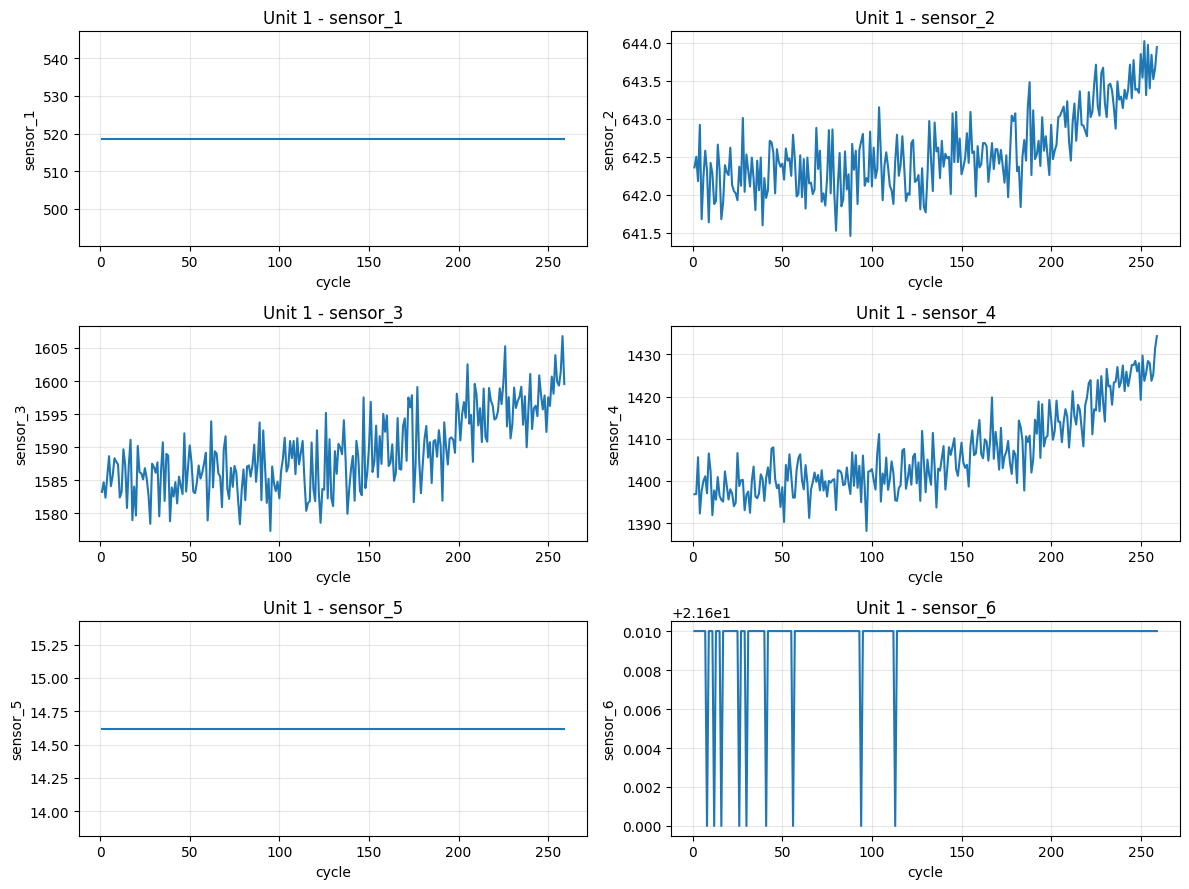

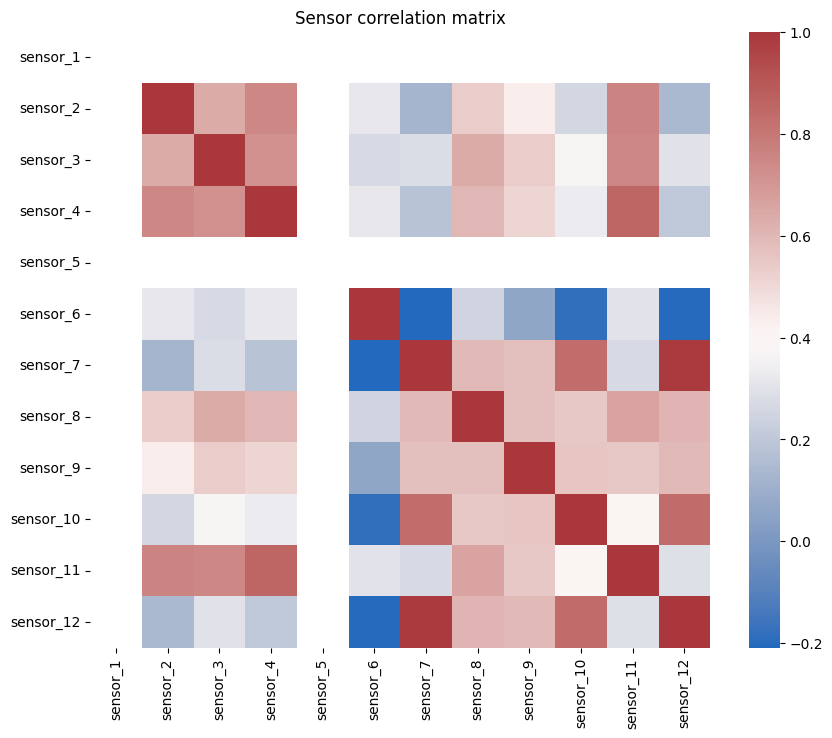

Done plotting.
✅ Successfully processed FD003
--- Processing FD004 ---
Train shape: (61249, 27), Test shape: (41214, 27)
Sensor summary stats (train):
                 mean         std      min      max
sensor_1   472.882435   26.436832   445.00   518.67
sensor_2   579.420056   37.342647   535.48   644.42
sensor_3  1417.896600  106.167598  1242.67  1613.00
sensor_4  1201.915359  119.327591  1024.42  1440.77
sensor_5     8.031626    3.622872     3.91    14.62


C:\Users\sghas\AppData\Local\Temp\ipykernel_21268\1862538827.py:184: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.67840701 -1.60094612 -0.60372913 ...  0.78525168 -0.56811424
 -0.60372913]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_t.loc[mask_train, cols] = scaler.transform(train_t.loc[mask_train, cols].values)
C:\Users\sghas\AppData\Local\Temp\ipykernel_21268\1862538827.py:184: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.56924473 -2.25650653 -0.10222091 ...  0.56924473 -0.17915969
 -0.17915969]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_t.loc[mask_train, cols] = scaler.transform(train_t.loc[mask_train, cols].values)
C:\Users\sghas\AppData\Local\Temp\ipykernel_21268\1862538827.py:186: FutureWarning: Setting 

Saved 7 cluster scalers and unit->cluster map for FD004
Saved processed files: ..\data\processed\CMAPSS\FD004\train_FD004.csv, ..\data\processed\CMAPSS\FD004\test_FD004.csv
Plotting EDA graphs for FD004...


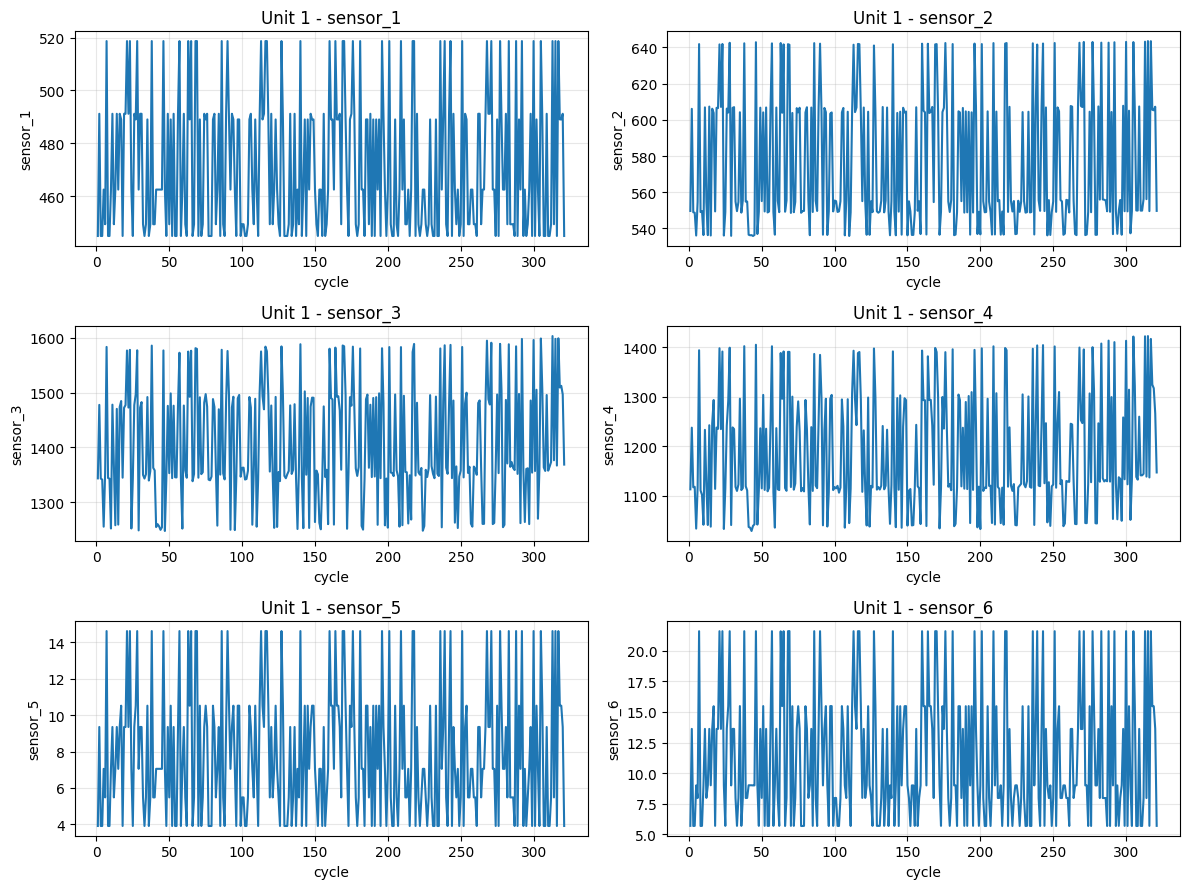

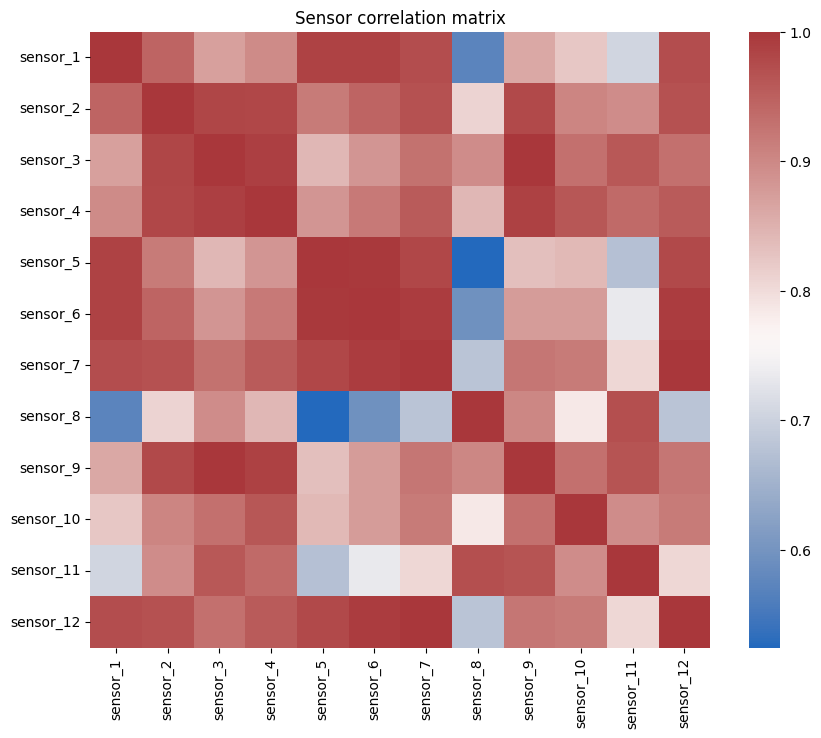

Done plotting.
✅ Successfully processed FD004

--- 🏁 All processing finished! ---

Sample Processed Data FD001 (Train):
   unit  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  \
0     1      1     -0.315980     -1.372953           0.0       0.0 -1.721725   
1     1      2      0.872722     -1.031720           0.0       0.0 -1.061780   
2     1      3     -1.961874      1.015677           0.0       0.0 -0.661813   
3     1      4      0.324090     -0.008022           0.0       0.0 -0.661813   
4     1      5     -0.864611     -0.690488           0.0       0.0 -0.621816   

   sensor_3  sensor_4      sensor_5  ...  sensor_13  sensor_14  sensor_15  \
0 -0.134255 -0.925936 -5.329071e-15  ...  -1.058890  -0.269071  -0.603816   
1  0.211528 -0.643726 -5.329071e-15  ...  -0.363646  -0.642845  -0.275852   
2 -0.413166 -0.525953 -5.329071e-15  ...  -0.919841  -0.551629  -0.649144   
3 -1.261314 -0.784831 -5.329071e-15  ...  -0.224597  -0.520176  -1.971665   
4 -1.251528 -0

In [1]:
"""
agentic_pm/data_ingest.py (Notebook-Safe Version)

Purpose:
- Load CMAPSS FD001-FD004 (expects files already downloaded into data/raw/CMAPSS)
- Parse files into pandas DataFrames with meaningful column names
- Compute RUL for train and test sets (per-row RUL for test by merging RUL_FD00X.txt)
- Provide EDA helpers (summary stats, sensor/time plots)
- Implement normalization strategies:
    - global_standardize (global StandardScaler)
    - conditional_standardize (cluster by operating-settings and standardize per-cluster)
- Save processed CSVs and fitted scalers for later pipeline stages

Dependencies: pandas, numpy, scikit-learn, matplotlib, seaborn, joblib
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --- Config
# NOTE: These paths will be overridden by the execution block at the end,
# but are kept here for context.
RAW_BASE_DEFAULT = Path("../data/raw/CMAPSS")
PROCESSED_BASE_DEFAULT = Path("../data/processed/CMAPSS")
SCALER_DIR_DEFAULT = Path("../artifacts/scalers")

# Column names for CMAPSS files (26 cols)
OP_COLS = ["op_setting_1", "op_setting_2", "op_setting_3"]
SENSOR_COLS = [f"sensor_{i}" for i in range(1, 22)]
COL_NAMES = ["unit", "cycle"] + OP_COLS + SENSOR_COLS

# Mapping for normalization strategy per subset
# FD001, FD003 -> global; FD002, FD004 -> conditional
NORMALIZATION_MAP = {
    "FD001": "global",
    "FD002": "conditional",
    "FD003": "global",
    "FD004": "conditional",
}


# ------------------------
# Core loading / parsing
# ------------------------

def read_cmapps_file(filepath: Path) -> pd.DataFrame:
    """Read a CMAPSS train or test txt file into DataFrame with proper column names."""
    df = pd.read_csv(filepath, sep="\s+", header=None, names=COL_NAMES)
    # ensure dtypes
    df["unit"] = df["unit"].astype(int)
    df["cycle"] = df["cycle"].astype(int)
    return df


def read_rul_file(filepath: Path) -> pd.Series:
    """Read RUL file (single column) and return a Series indexed by unit (1-based)."""
    # [FIX] 'squeeze=True' is deprecated. Replaced with .read_csv(...).squeeze("columns")
    rul = pd.read_csv(filepath, header=None).squeeze("columns")
    rul.index = np.arange(1, len(rul) + 1)  # unit ids are 1..N
    rul.name = "RUL"
    return rul


def compute_train_rul(df_train: pd.DataFrame) -> pd.DataFrame:
    """Add RUL column to train DataFrame: RUL = max_cycle_for_unit - cycle"""
    max_cycle = df_train.groupby("unit")["cycle"].transform("max")
    df = df_train.copy()
    df["RUL"] = max_cycle - df["cycle"]
    return df


def compute_test_rul(df_test: pd.DataFrame, rul_series: pd.Series) -> pd.DataFrame:
    """Compute per-row RUL for test set by merging per-unit RUL (remaining after last observed cycle).

    For each unit:
        final_cycle = max(cycle observed in test for that unit)
        RUL_at_final = rul_series.loc[unit]
    For a row with cycle c:
        row_RUL = RUL_at_final + (final_cycle - c)

    Returns a new DataFrame with RUL column.
    """
    df = df_test.copy()
    final_cycles = df.groupby("unit")["cycle"].transform("max")
    # Map per-unit remaining life at last observed cycle
    df = df.merge(rul_series.rename("RUL_unit"), left_on="unit", right_index=True)
    df["RUL"] = df["RUL_unit"] + (final_cycles - df["cycle"])
    df.drop(columns=["RUL_unit"], inplace=True)
    return df


# ------------------------
# Normalization methods
# ------------------------

def global_standardize(train_df: pd.DataFrame, test_df: pd.DataFrame, scaler_dir: Path, cols: list = None, subset_name: str = "FD"):
    """Fit StandardScaler on train_df[cols] (global) and transform both train and test.
    Saves scaler to artifacts/scalers/{subset_name}_global_scaler.pkl
    Returns transformed (train, test) and scaler.
    """
    if cols is None:
        cols = SENSOR_COLS + OP_COLS
    scaler = StandardScaler()
    X_train = train_df[cols].values
    X_test = test_df[cols].values
    scaler.fit(X_train)
    
    train_t = train_df.copy()
    test_t = test_df.copy()
    train_t[cols] = scaler.transform(X_train)
    test_t[cols] = scaler.transform(X_test)
    
    scaler_path = scaler_dir / f"{subset_name}_global_scaler.pkl"
    joblib.dump(scaler, scaler_path)
    print(f"Saved global scaler to {scaler_path}")
    return train_t, test_t, scaler


def conditional_standardize(train_df: pd.DataFrame, test_df: pd.DataFrame, scaler_dir: Path, n_clusters: int = 6, subset_name: str = "FD"):
    """Cluster units by their operating settings (mean across cycles) and standardize sensor+op features per-cluster.
    
    [FIX] Added n_init=10 to KMeans to suppress FutureWarnings.
    [FIX] Added fallback logic for units in test set not seen in train set.
    """
    # compute unit-level op means
    unit_means = train_df.groupby("unit")[OP_COLS].mean().reset_index()
    X = unit_means[OP_COLS].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    unit_means["cluster"] = labels

    # map unit -> cluster
    unit_cluster = dict(zip(unit_means["unit"], unit_means["cluster"]))

    # create copies
    train_t = train_df.copy()
    test_t = test_df.copy()
    scalers = {}

    # assign cluster column
    train_t["cluster"] = train_t["unit"].map(unit_cluster)
    test_t["cluster"] = test_t["unit"].map(unit_cluster)
    
    # [FIX] Handle units in test set that were not in train set
    test_t["cluster"] = test_t["cluster"].fillna(-1) # Assign to a temporary cluster

    cols = SENSOR_COLS + OP_COLS
    
    # Fit a global scaler as a fallback for cluster -1 or small clusters
    fallback_scaler = StandardScaler().fit(train_df[cols].values)
    scalers[-1] = fallback_scaler # Store for cluster -1

    for c in sorted(train_t["cluster"].unique()):
        mask_train = train_t["cluster"] == c
        Xc_train = train_t.loc[mask_train, cols]
        
        # If cluster has no train rows (very unlikely), use fallback
        if Xc_train.shape[0] < 2:
            scaler = fallback_scaler
        else:
            scaler = StandardScaler()
            scaler.fit(Xc_train.values)
            
        scalers[c] = scaler
        joblib.dump(scaler, scaler_dir / f"{subset_name}_cluster_{c}_scaler.pkl")

    # Now transform all data using the fitted scalers
    all_clusters = np.union1d(train_t["cluster"].unique(), test_t["cluster"].unique())
    for c in all_clusters:
        mask_train = train_t["cluster"] == c
        mask_test = test_t["cluster"] == c
        
        # Use the specific cluster scaler, or the fallback scaler if cluster key doesn't exist
        scaler = scalers.get(c, fallback_scaler) 

        if mask_train.sum() > 0:
            train_t.loc[mask_train, cols] = scaler.transform(train_t.loc[mask_train, cols].values)
        if mask_test.sum() > 0:
            test_t.loc[mask_test, cols] = scaler.transform(test_t.loc[mask_test, cols].values)

    # also save unit->cluster mapping
    joblib.dump(unit_cluster, scaler_dir / f"{subset_name}_unit_cluster_map.pkl")
    print(f"Saved {len(scalers)} cluster scalers and unit->cluster map for {subset_name}")
    return train_t, test_t, scalers, unit_cluster


# ------------------------
# EDA / Visualization
# ------------------------

def summary_stats(df: pd.DataFrame) -> pd.DataFrame:
    """Compute summary statistics for sensor columns (mean, std, min, max)"""
    stats = df[SENSOR_COLS].agg(["mean", "std", "min", "max"]).T
    stats.columns = ["mean", "std", "min", "max"]
    return stats


def plot_unit_sensors(df: pd.DataFrame, unit_id: int, sensors: list = None, nrows: int = None):
    """Plot time-series for a given unit for selected sensors."""
    if sensors is None:
        sensors = SENSOR_COLS[:6]
    unit_df = df[df["unit"] == unit_id]
    n = len(sensors)
    if nrows is None:
        nrows = int(np.ceil(n / 2))
    plt.figure(figsize=(12, 3 * nrows))
    for i, s in enumerate(sensors, 1):
        plt.subplot(nrows, 2, i)
        plt.plot(unit_df["cycle"], unit_df[s])
        plt.title(f"Unit {unit_id} - {s}")
        plt.xlabel("cycle")
        plt.ylabel(s)
        plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_sensor_over_units(df: pd.DataFrame, sensor: str, sample_units: list = None, ncols: int = 2):
    """Overlay sensor traces from several units to see variability."""
    if sample_units is None:
        sample_units = df["unit"].unique()[:6]
    n = len(sample_units)
    plt.figure(figsize=(12, 3 * int(np.ceil(n / ncols))))
    for i, u in enumerate(sample_units, 1):
        plt.subplot(int(np.ceil(n / ncols)), ncols, i)
        tmp = df[df["unit"] == u]
        plt.plot(tmp["cycle"], tmp[sensor])
        plt.title(f"Unit {u}")
    plt.tight_layout()
    plt.show()


def plot_correlation_heatmap(df: pd.DataFrame, sensors: list = None):
    if sensors is None:
        sensors = SENSOR_COLS[:12]
    corr = df[sensors].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap="vlag")
    plt.title("Sensor correlation matrix")
    plt.show()


# ------------------------
# Top-level processing per subset
# ------------------------

def process_subset(subset: str, raw_base: Path, processed_base: Path, scaler_dir: Path, n_clusters: int = 6):
    """Load, compute RUL, normalize according to NORMALIZATION_MAP, run basic EDA plots, and save CSVs/scalers.
    
    This function now takes paths as arguments to be notebook-friendly.
    """
    subset = subset.upper()
    print(f"--- Processing {subset} ---")
    train_f = raw_base / f"train_{subset}.txt"
    test_f = raw_base / f"test_{subset}.txt"
    rul_f = raw_base / f"RUL_{subset}.txt"

    if not (train_f.exists() and test_f.exists() and rul_f.exists()):
        raise FileNotFoundError(f"Missing files for {subset} in {raw_base.resolve()}. Expected {train_f.name}, {test_f.name}, {rul_f.name}.")

    train_df = read_cmapps_file(train_f)
    test_df = read_cmapps_file(test_f)
    rul_series = read_rul_file(rul_f)

    train_df = compute_train_rul(train_df)
    test_df = compute_test_rul(test_df, rul_series)

    # Basic EDA: show shape and sensor stats
    print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
    stats = summary_stats(train_df)
    print("Sensor summary stats (train):")
    print(stats.head())

    # Choose normalization
    norm = NORMALIZATION_MAP.get(subset, "global")
    if norm == "global":
        train_t, test_t, _ = global_standardize(train_df, test_df, scaler_dir, cols=None, subset_name=subset)
    else:
        train_t, test_t, _, _ = conditional_standardize(train_df, test_df, scaler_dir, n_clusters=n_clusters, subset_name=subset)

    # Save processed
    processed_dir = processed_base / subset
    processed_dir.mkdir(parents=True, exist_ok=True)
    train_out = processed_dir / f"train_{subset}.csv"
    test_out = processed_dir / f"test_{subset}.csv"
    train_t.to_csv(train_out, index=False)
    test_t.to_csv(test_out, index=False)
    print(f"Saved processed files: {train_out}, {test_out}")

    # Quick plots (show first unit)
    first_unit = train_df["unit"].unique()[0]
    try:
        print(f"Plotting EDA graphs for {subset}...")
        plot_unit_sensors(train_df, first_unit, sensors=SENSOR_COLS[:6])
        plot_correlation_heatmap(train_df)
        print("Done plotting.")
    except Exception as e:
        print("Plotting failed (this can happen in some non-interactive environments):", e)

    return {
        "train": train_t,
        "test": test_t,
        "stats": stats,
        "normalization": norm,
    }


# ------------------------
# Helper: run pipeline for all FD001-FD004
# ------------------------

def run_all(subsets: list, raw_base: Path, processed_base: Path, scaler_dir: Path):
    """
    Runs process_subset for all items in the list, passing the required paths.
    """
    if subsets is None:
        subsets = ["FD001", "FD002", "FD003", "FD004"]
    results = {}
    for s in subsets:
        try:
            results[s] = process_subset(s, raw_base, processed_base, scaler_dir)
            print(f"✅ Successfully processed {s}")
        except Exception as e:
            print(f"!!!!!!!! ❌ FAILED to process {s}: {e} !!!!!!!!")
            # Optionally, re-raise the error if you want execution to stop
            # raise e
    return results


##################################################################
# 🚀 NOTEBOOK EXECUTION BLOCK
# This replaces the `if __name__ == "__main__":` block.
# All code above this line just *defines* the functions.
# This block *runs* them.
##################################################################

print("==============================================")
print("🚀 Starting Data Ingestion Script in Notebook...")
print("==============================================")

# --- 1. [IMPORTANT] Define Your Paths Here ---
# Assume this notebook is running in the *project root* directory.
# (i.e., the same folder that contains 'data', 'artifacts', 'agentic_pm')
PROJECT_ROOT = Path(".") 

# Define the main paths
NOTEBOOK_RAW_BASE = PROJECT_ROOT / "../data/raw/CMAPSS"
NOTEBOOK_PROCESSED_BASE = PROJECT_ROOT / "../data/processed/CMAPSS"
NOTEBOOK_SCALER_DIR = PROJECT_ROOT / "../artifacts/scalers"

# --- 2. Create Directories ---
NOTEBOOK_PROCESSED_BASE.mkdir(parents=True, exist_ok=True)
NOTEBOOK_SCALER_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Root: {PROJECT_ROOT.resolve()}")
print(f"Loading Raw Data From: {NOTEBOOK_RAW_BASE.resolve()}")
print(f"Saving Processed Data To: {NOTEBOOK_PROCESSED_BASE.resolve()}")
print(f"Saving Scalers To: {NOTEBOOK_SCALER_DIR.resolve()}")


# --- 3. Run the Pipeline ---

# == Option A: Run one subset for a quick test ==
# subsets_to_run = ["FD001"] 

# == Option B: Run all subsets ==
subsets_to_run = ["FD001", "FD002", "FD003", "FD004"]


# Call the modified `run_all` function
all_results = run_all(
    subsets=subsets_to_run,
    raw_base=NOTEBOOK_RAW_BASE,
    processed_base=NOTEBOOK_PROCESSED_BASE,
    scaler_dir=NOTEBOOK_SCALER_DIR
)

print("\n--- 🏁 All processing finished! ---")

# --- 4. Display Results in Notebook ---
if "FD001" in all_results:
    print("\nSample Processed Data FD001 (Train):")
    print(all_results["FD001"]["train"].head())

if "FD002" in all_results:
    print("\nSample Processed Data FD002 (Test):")
    print(all_results["FD002"]["test"].head())